In [34]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')






In [35]:

customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [36]:

print("Customers Data:\n", customers.head(), "\n")



Customers Data:
   CustomerID        CustomerName         Region SignupDate
0      C0001    Lawrence Carroll  South America 2022-07-10
1      C0002      Elizabeth Lutz           Asia 2022-02-13
2      C0003      Michael Rivera  South America 2024-03-07
3      C0004  Kathleen Rodriguez  South America 2022-10-09
4      C0005         Laura Weber           Asia 2022-08-15 



In [37]:
print("Transactions Data:\n", transactions.head(), "\n")

Transactions Data:
   TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00272      C0087      P067 2024-03-26 22:55:37         2   
4        T00363      C0070      P067 2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68   



In [38]:
print("Products Data:\n", products.head(), "\n")

Products Data:
   ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31 



In [39]:
data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

print("Merged Data Info:\n", data.info())
print("\nSummary Statistics:\n", data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price_x          1000 non-null   float64       
 7   CustomerName     1000 non-null   object        
 8   Region           1000 non-null   object        
 9   SignupDate       1000 non-null   datetime64[ns]
 10  ProductName      1000 non-null   object        
 11  Category         1000 non-null   object        
 12  Price_y          1000 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(7)
memory usage: 101.7+ KB
Merged Data Info

In [40]:
most_purchased = data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(5)
print("\nTop 5 Most Purchased Products:\n", most_purchased)


Top 5 Most Purchased Products:
 ProductName
ActiveWear Smartwatch    100
SoundWave Headphones      97
HomeSense Desk Lamp       81
ActiveWear Rug            79
SoundWave Cookbook        78
Name: Quantity, dtype: int64


In [41]:
revenue_by_region = data.groupby('Region')['TotalValue'].sum()
print("\nTotal Revenue by Region:\n", revenue_by_region)


Total Revenue by Region:
 Region
Asia             152074.97
Europe           166254.63
North America    152313.40
South America    219352.56
Name: TotalValue, dtype: float64


In [42]:
data['Month'] = data['TransactionDate'].dt.to_period('M')
monthly_revenue = data.groupby('Month')['TotalValue'].sum()

<ipython-input-43-b16a22c870fe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Region', data=customers, palette='viridis')


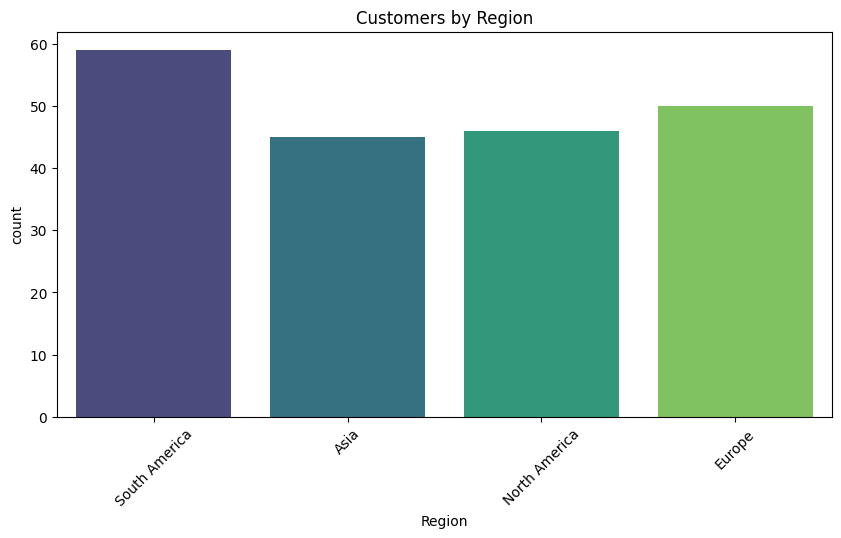

In [43]:
#customers by Region
plt.figure(figsize=(10, 5))
sns.countplot(x='Region', data=customers, palette='viridis')
plt.title('Customers by Region')
plt.xticks(rotation=45)
plt.show()

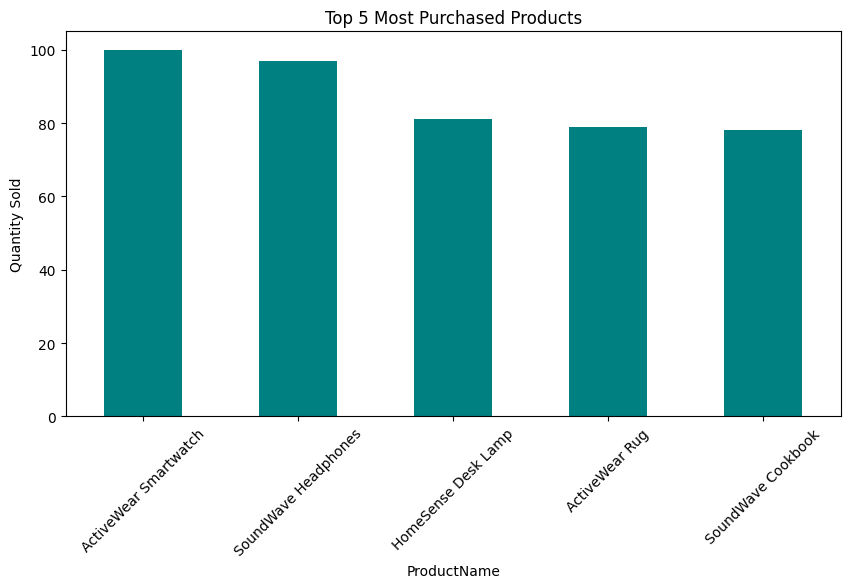

In [44]:
#Top 5 Most Purchased Products
most_purchased.plot(kind='bar', figsize=(10, 5), color='teal')
plt.title('Top 5 Most Purchased Products')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()

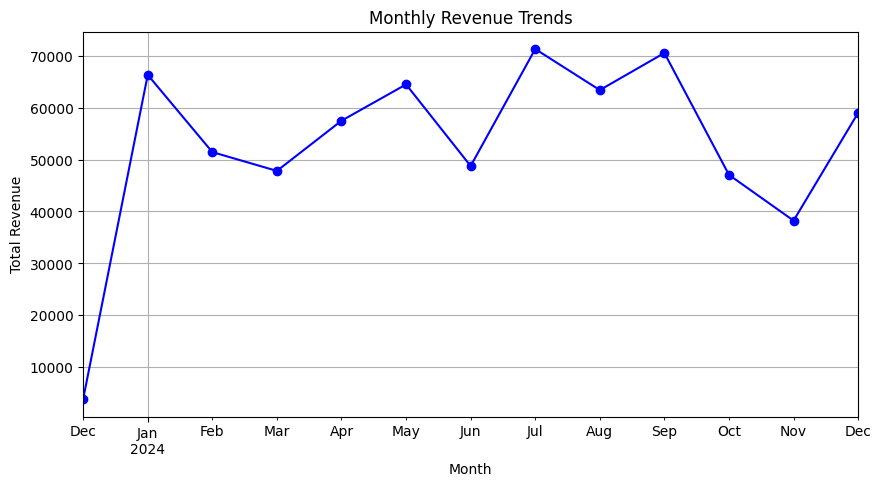

In [45]:
#   Monthly Revenue Trends
monthly_revenue.plot(kind='line', figsize=(10, 5), marker='o', color='blue')
plt.title('Monthly Revenue Trends')
plt.ylabel('Total Revenue')
plt.xlabel('Month')
plt.grid()
plt.show()


In [46]:
print(data.columns)

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y', 'Month'],
      dtype='object')


In [47]:
# Prepare Customer Data for Lookalike Model
customer_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price_y': 'mean'
}).reset_index()


In [48]:
# Normalize Data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(customer_data[['TotalValue', 'Quantity', 'Price_y']])

In [49]:
# Calculate Similarity Matrix
similarity_matrix = cosine_similarity(normalized_data)

In [50]:
# Generate Lookalike Recommendations
top_lookalikes = {}
for i, customer_id in enumerate(customer_data['CustomerID'][:20]):
    similar_customers = sorted(list(enumerate(similarity_matrix[i])), key=lambda x: x[1], reverse=True)[1:4]
    top_lookalikes[customer_id] = [(customer_data['CustomerID'][j], round(score, 2)) for j, score in similar_customers]